In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mvf_bto.data_loading import load_data
from mvf_bto.constants import * 
from mvf_bto.models.one_shot import OneShot
from mvf_bto.preprocessing.one_shot import create_discharge_inputs, REFERENCE_DISCHARGE_CAPACITIES

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanSquaredError
import tensorflow as tf
from scipy.interpolate import interp1d

from tensorflow import keras
from keras_tuner.tuners import RandomSearch

import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go

## Loading Data

In [3]:
# data_path = "/Users/anoushkabhutani/PycharmProjects/10701-mvf-bto/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"
# data_path = "/Users/mac/Desktop/CMU/10701MachineLearning/project/10701-mvf-bto-backup/data/2017-05-12_batchdata_updated_struct_errorcorrect.mat"
data_path=[]
data_path.append("2017-05-12_batchdata_updated_struct_errorcorrect.mat")
data_path.append("2017-06-30_batchdata_updated_struct_errorcorrect.mat")
data_path.append("2018-04-12_batchdata_updated_struct_errorcorrect.mat")
num_cells=[46,48,46]

In [ ]:
data ={}
for i in range(3):
    data.update(load_data(file_path=data_path[i], 
                               num_cells=num_cells[i], 
                               batch_id = i))

  8%|▊         | 4/48 [00:11<02:10,  2.98s/it]

## Preprocess Datasets

In [10]:
train_split = 0.7
test_split = 0.2
history_window = 16

datasets = create_discharge_inputs(data, train_split, test_split, history_window=history_window)

 Data for cell b1c3 is corrupted. Skipping cell.
 Data for cell b1c8 is corrupted. Skipping cell.
 Data for cell b1c28 is corrupted. Skipping cell.


100%|██████████| 598/598 [00:03<00:00, 157.63it/s]


## Model Training

In [11]:
n_features = datasets['X_train'].shape[-1]
output_dimension = datasets['y_train'].shape[-1]
input_shape=(history_window, n_features)

In [37]:
def build_model(hp):
    model = keras.Sequential([
        keras.layers.Conv1D(
            filters=64,
            kernel_size=2,
            activation=hp.Choice('conv_activation',values=['relu', 'sigmoid', 'leaky_relu', 'tanh'],default='relu'),
            input_shape = input_shape
    ),
    keras.layers.MaxPooling1D(
        pool_size=2
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation=hp.Choice('dense_activation',values=['relu', 'sigmoid', 'leaky_relu', 'tanh'],default='relu'),
    ),
    keras.layers.Dense(units=output_dimension),
    ])

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                  loss=custom_loss_function,
                  metrics=[MeanSquaredError()])

    return model

tuner= RandomSearch(
        build_model,
        objective='val_mean_squared_error',
        max_trials=15,
        executions_per_trial=1
        )

tuner.search(datasets['X_train'], datasets['y_train'], epochs=8, validation_data=(datasets['X_test'], datasets['y_test']))
best_model = tuner.get_best_models()[0]

Trial 15 Complete [00h 00m 28s]
val_mean_squared_error: 0.0021269680000841618

Best val_mean_squared_error So Far: 0.0011209890944883227
Total elapsed time: 00h 07m 09s
INFO:tensorflow:Oracle triggered exit


In [38]:
def custom_loss_function(y_true, y_pred):   
    split = y_true.shape[-1]//2
    return tf.reduce_mean((y_true[:,:split]-y_pred[:,:split])**2 + 10*(y_true[:,split:]-y_pred[:,split:])**2, axis=-1)

In [7]:
def custom_loss_function(y_true, y_pred):   
    split = y_true.shape[-1]//2
    return tf.reduce_mean((y_true[:,:split]-y_pred[:,:split])**2 + 10*(y_true[:,split:]-y_pred[:,split:])**2, axis=-1)


model = OneShot(input_shape=input_shape, n_outputs=output_dimension)

es = EarlyStopping(
    monitor="val_mean_squared_error",
    min_delta=0,
    patience=80,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.96)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss=custom_loss_function, 
              metrics=[MeanSquaredError()])

history = model.fit(
    datasets["X_train"],
    datasets["y_train"],
    validation_data=(datasets["X_val"], datasets["y_val"]),
    epochs=500,
    callbacks=[es],
    batch_size=128,
    shuffle=False,
    verbose=1,

)

2022-12-12 23:05:44.944180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-12 23:05:44.944345: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-12 23:05:44.944391: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (model-training-v1): /proc/driver/nvidia/version does not exist
2022-12-12 23:05:44.979092: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/500
195/195 [==============================] - 5s 8ms/step - loss: 0.1750 - mean_squared_error: 0.0176 - val_loss: 0.2276 - val_mean_squared_error: 0.0128
Epoch 2/500
195/195 [==============================] - 1s 6ms/step - loss: 0.0913 - mean_squared_error: 0.0077 - val_loss: 0.1357 - val_mean_squared_error: 0.0074
Epoch 3/500
195/195 [==============================] - 1s 7ms/step - loss: 0.0822 - mean_squared_error: 0.0054 - val_loss: 0.1656 - val_mean_squared_error: 0.0086
Epoch 4/500
195/195 [==============================] - 1s 6ms/step - loss: 0.0741 - mean_squared_error: 0.0042 - val_loss: 0.1408 - val_mean_squared_error: 0.0073
Epoch 5/500
195/195 [==============================] - 1s 6ms/step - loss: 0.1070 - mean_squared_error: 0.0058 - val_loss: 0.1701 - val_mean_squared_error: 0.0088
Epoch 6/500
195/195 [==============================] - 1s 6ms/step - loss: 0.1021 - mean_squared_error: 0.0054 - val_loss: 0.1591 - val_mean_squared_error: 0.0082
Epoch 7/500
195/195 [=

In [40]:
es = EarlyStopping(
    monitor="val_mean_squared_error",
    min_delta=0,
    patience=80,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)


history = best_model.fit(
    datasets["X_train"],
    datasets["y_train"],
    validation_data=(datasets["X_val"], datasets["y_val"]),
    epochs=500,
    callbacks=[es],
    batch_size=128,
    shuffle=False,
    verbose=1,

)

Epoch 1/500
195/195 [==============================] - 3s 8ms/step - loss: 0.1035 - mean_squared_error: 0.0065 - val_loss: 0.1238 - val_mean_squared_error: 0.0064
Epoch 2/500
195/195 [==============================] - 1s 7ms/step - loss: 0.1282 - mean_squared_error: 0.0067 - val_loss: 0.1288 - val_mean_squared_error: 0.0067
Epoch 3/500
195/195 [==============================] - 1s 6ms/step - loss: 0.1281 - mean_squared_error: 0.0067 - val_loss: 0.1266 - val_mean_squared_error: 0.0066
Epoch 4/500
195/195 [==============================] - 1s 6ms/step - loss: 0.1275 - mean_squared_error: 0.0067 - val_loss: 0.1248 - val_mean_squared_error: 0.0065
Epoch 5/500
195/195 [==============================] - 1s 6ms/step - loss: 0.1270 - mean_squared_error: 0.0066 - val_loss: 0.1235 - val_mean_squared_error: 0.0064
Epoch 6/500
195/195 [==============================] - 1s 6ms/step - loss: 0.1266 - mean_squared_error: 0.0066 - val_loss: 0.1226 - val_mean_squared_error: 0.0064
Epoch 7/500
195/195 [=

In [41]:
pd.DataFrame({"loss": history.history['loss']}).to_csv("oneshot_hp_history.csv")

In [43]:
# import tensorflow as tf
# model = tf.keras.models.load_model("oneshot_hp",custom_objects = {'custom_loss_function':custom_loss_function})

## Parity Plots

213/213 [==============================] - 0s 2ms/step


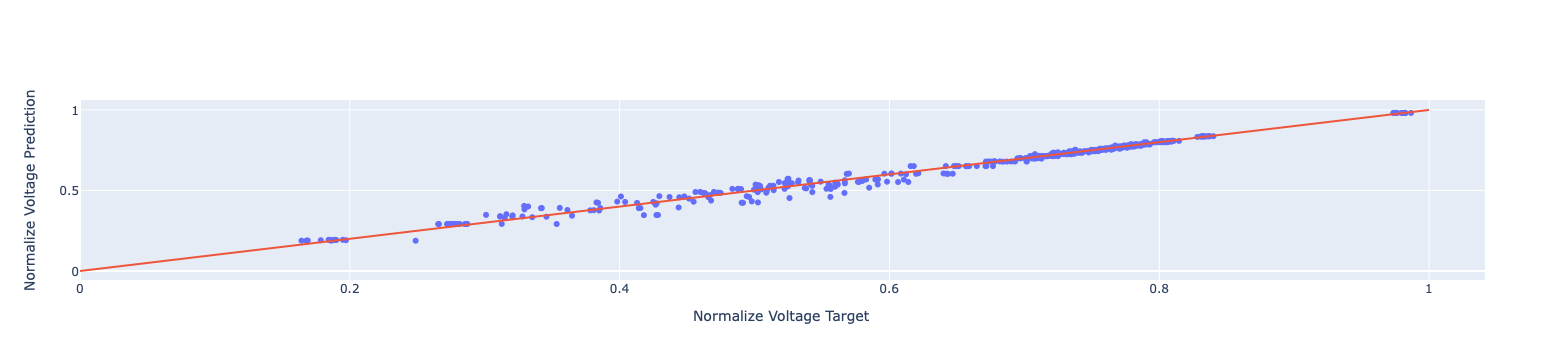

In [44]:
skip = 1000
yhat = model.predict(datasets['X_test'])
y_test = datasets['y_test']
fig = go.Figure()
fig.add_trace(go.Scatter(x = y_test[:, :y_test.shape[-1]//2].flatten()[::skip],
                         y= yhat[:, :y_test.shape[-1]//2].flatten()[::skip], mode="markers", showlegend=False))
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], mode="lines", showlegend=False))
fig.update_xaxes(title='Normalize Voltage Target')
fig.update_yaxes(title='Normalize Voltage Prediction')

213/213 [==============================] - 0s 2ms/step


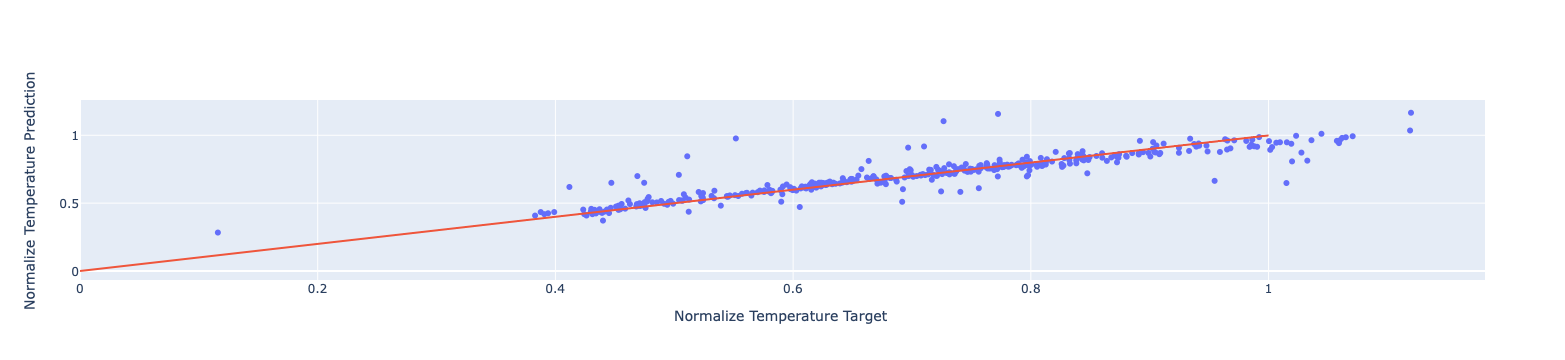

In [45]:
yhat = model.predict(datasets['X_test'])
y_test = datasets['y_test']
fig = go.Figure()
fig.add_trace(go.Scatter(x = y_test[:, y_test.shape[-1]//2:].flatten()[::skip],
                         y= yhat[:, y_test.shape[-1]//2:].flatten()[::skip], mode="markers", showlegend=False))
fig.add_trace(go.Scatter(x = [0,1], y=[0,1], mode="lines", showlegend=False))
fig.update_xaxes(title='Normalize Temperature Target')
fig.update_yaxes(title='Normalize Temperature Prediction')

## Predicted vs Actual Traces

In [46]:
pallete = plotly.colors.qualitative.Dark24 + plotly.colors.qualitative.T10
pallete = pallete*70000

In [47]:

labels = list(datasets['original_test'].groupby(["Cycle", "Cell"]).groups.keys())
fig = go.Figure()
for i in range(10,len(yhat), 1000):
    fig.add_trace(go.Scatter(x = datasets['q_eval_test'][i], marker_color=pallete[i], 
                             name = f"Cell {labels[i][1]} Cycle {labels[i][0]}",
                             y=y_test[i][:y_test.shape[-1]//2], mode="lines"))
    fig.add_trace(go.Scatter(x = datasets['q_eval_test'][i], line_color=pallete[i], name = "Prediction",
                             y=yhat[i][:yhat.shape[-1]//2], mode="markers"))

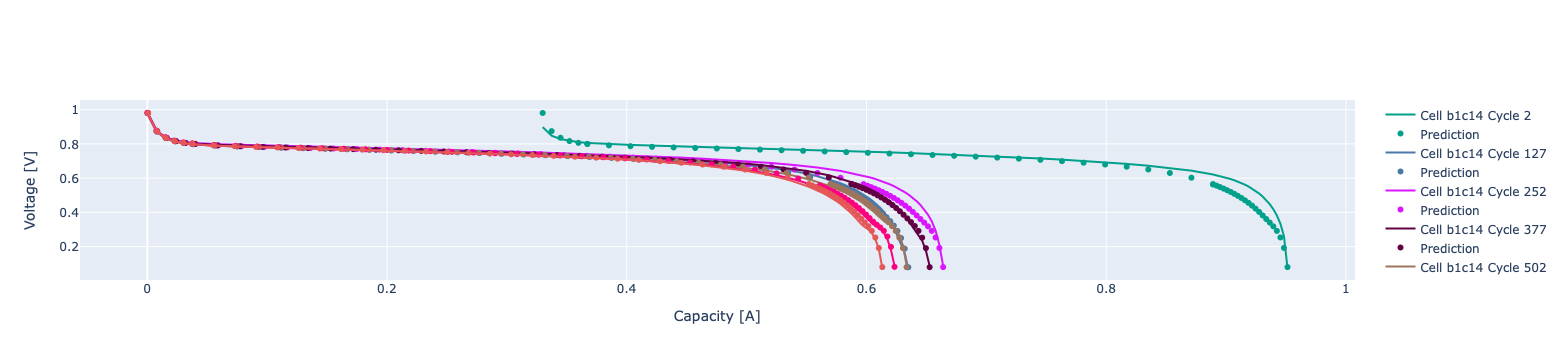

In [48]:
fig.update_xaxes(title='Capacity [A]')
fig.update_yaxes(title='Voltage [V]')

In [49]:
yhat = model.predict(datasets['X_test'])
y_test = datasets['y_test']
labels = list(datasets['original_test'].groupby(["Cycle", "Cell"]).groups.keys())
fig = go.Figure()
for i in range(10,len(yhat), 1000):
    fig.add_trace(go.Scatter(x = datasets['q_eval_test'][i], marker_color=pallete[i], 
                             name = f"Cell {labels[i][1]} Cycle {labels[i][0]}",
                             y=y_test[i][y_test.shape[-1]//2:], mode="lines"))
    fig.add_trace(go.Scatter(x = datasets['q_eval_test'][i], line_color=pallete[i], name = "Prediction",
                             y=yhat[i][yhat.shape[-1]//2:], mode="markers"))

213/213 [==============================] - 0s 2ms/step


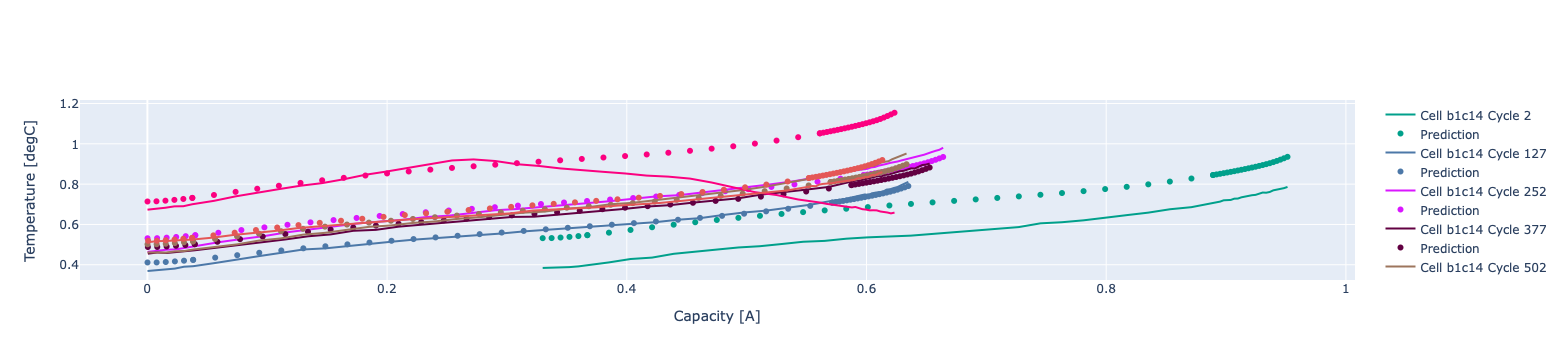

In [50]:
fig.update_xaxes(title='Capacity [A]')
fig.update_yaxes(title='Temperature [degC]')

127/127 [==============================] - 0s 2ms/step
4055 4055


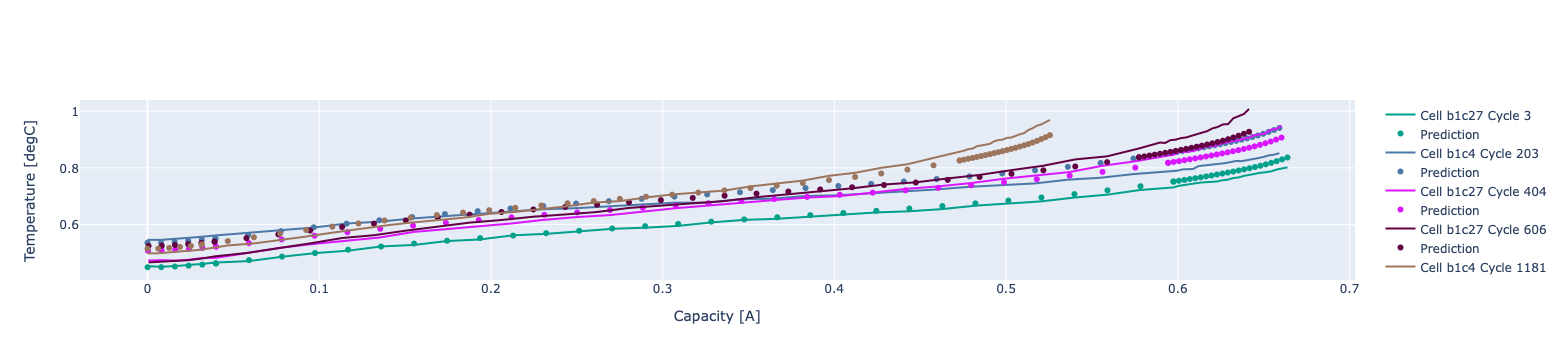

In [51]:
yhat = model.predict(datasets['X_val'])
y_test = datasets['y_val']
print(len(yhat),len(y_test))
labels = list(datasets['original_val'].groupby(["Cycle", "Cell"]).groups.keys())
fig = go.Figure()
for i in range(10,len(yhat), 1000):
    fig.add_trace(go.Scatter(x = datasets['q_eval_val'][i], marker_color=pallete[i], 
                             name = f"Cell {labels[i][1]} Cycle {labels[i][0]}",
                             y=y_test[i][y_test.shape[-1]//2:], mode="lines"))
    fig.add_trace(go.Scatter(x = datasets['q_eval_val'][i], line_color=pallete[i], name = "Prediction",
                             y=yhat[i][yhat.shape[-1]//2:], mode="markers"))
    
fig.update_xaxes(title='Capacity [A]')
fig.update_yaxes(title='Temperature [degC]')

In [24]:
print(len(datasets['q_eval_val']))

0


In [52]:
model.save("oneshot_hp")

INFO:tensorflow:Assets written to: oneshot_hp/assets


INFO:tensorflow:Assets written to: oneshot_hp/assets
